In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [27]:
df = pd.read_csv('PJME_hourly.csv')
df =df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


Text(0, 0.5, 'Consumption in MW')

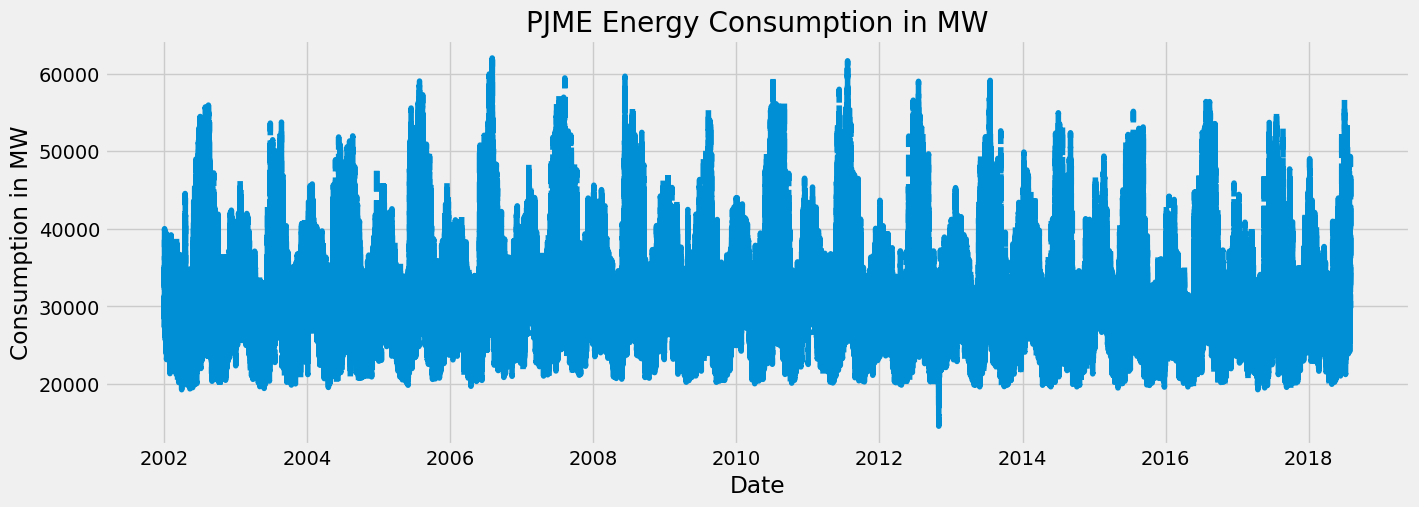

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(df, linestyle= '--')
plt.title('PJME Energy Consumption in MW')
plt.xlabel('Date')
plt.ylabel('Consumption in MW')



Text(0, 0.5, 'Freq')

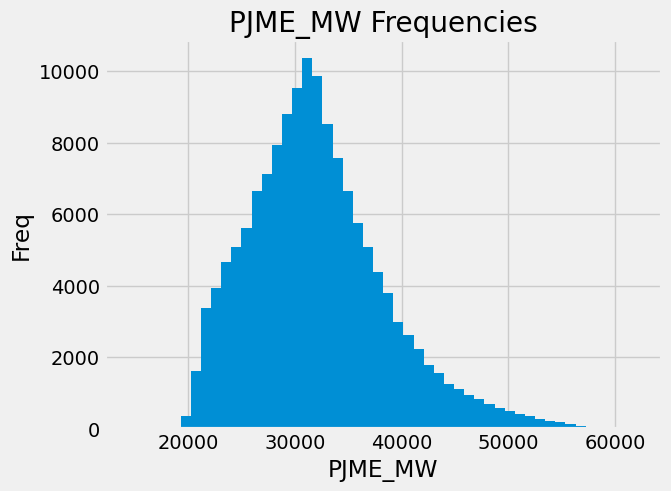

In [29]:
plt.hist(df['PJME_MW'], bins= 50)
plt.title('PJME_MW Frequencies')
plt.xlabel('PJME_MW')
plt.ylabel('Freq')

In [30]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [31]:
# despite having skewness, but if we treate it as a normal distribution and assume almost 
# 95% of the data fall within 2 std from the mean, we can locate where are our outliers.
majority_upper_bound = df['PJME_MW'].mean() + 2*6464.012166
majority_lower_bound = df['PJME_MW'].mean() - 2*6464.012166
majority_lower_bound, majority_upper_bound

(19152.198498648155, 45008.24716264816)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

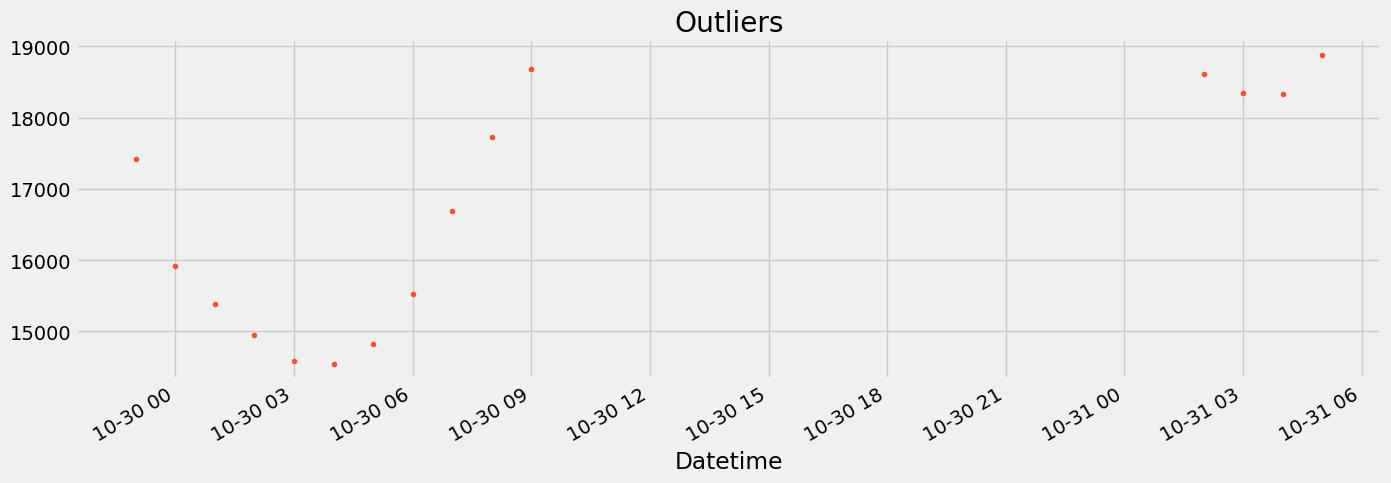

In [32]:
# now we can say that this lower peak is for values below 19K
df.query('PJME_MW < 19000')['PJME_MW'] \
        .plot(style= '.',
              figsize= (15, 5),
              color = color_pal[1],
              title= 'Outliers')

In [33]:
df = df.query('PJME_MW > 19000').copy()

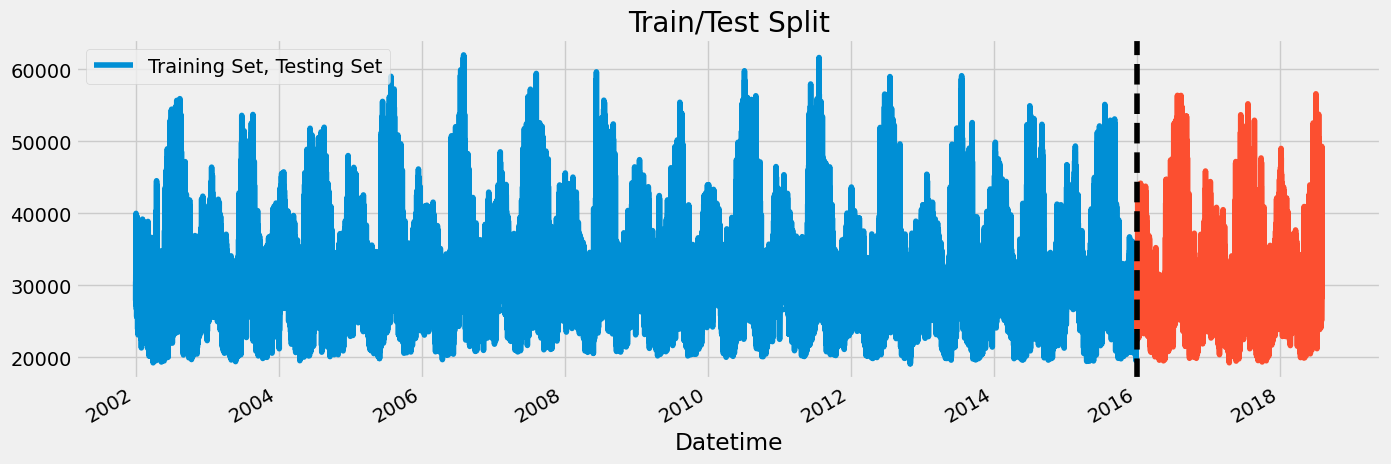

In [34]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax=ax, label= 'Training Set', title= 'Train/Test Split')
test.plot(ax=ax, label= 'Test set')
ax.axvline('01-01-2016', color= 'black', ls= '--')
ax.legend(['Training Set, Testing Set'])
plt.show()

In [35]:
tss = TimeSeriesSplit(n_splits= 5, test_size= 24*365*1, gap= 0)
# This way, you are oging to train your model to predict a whole year ahead
df = df.sort_index()

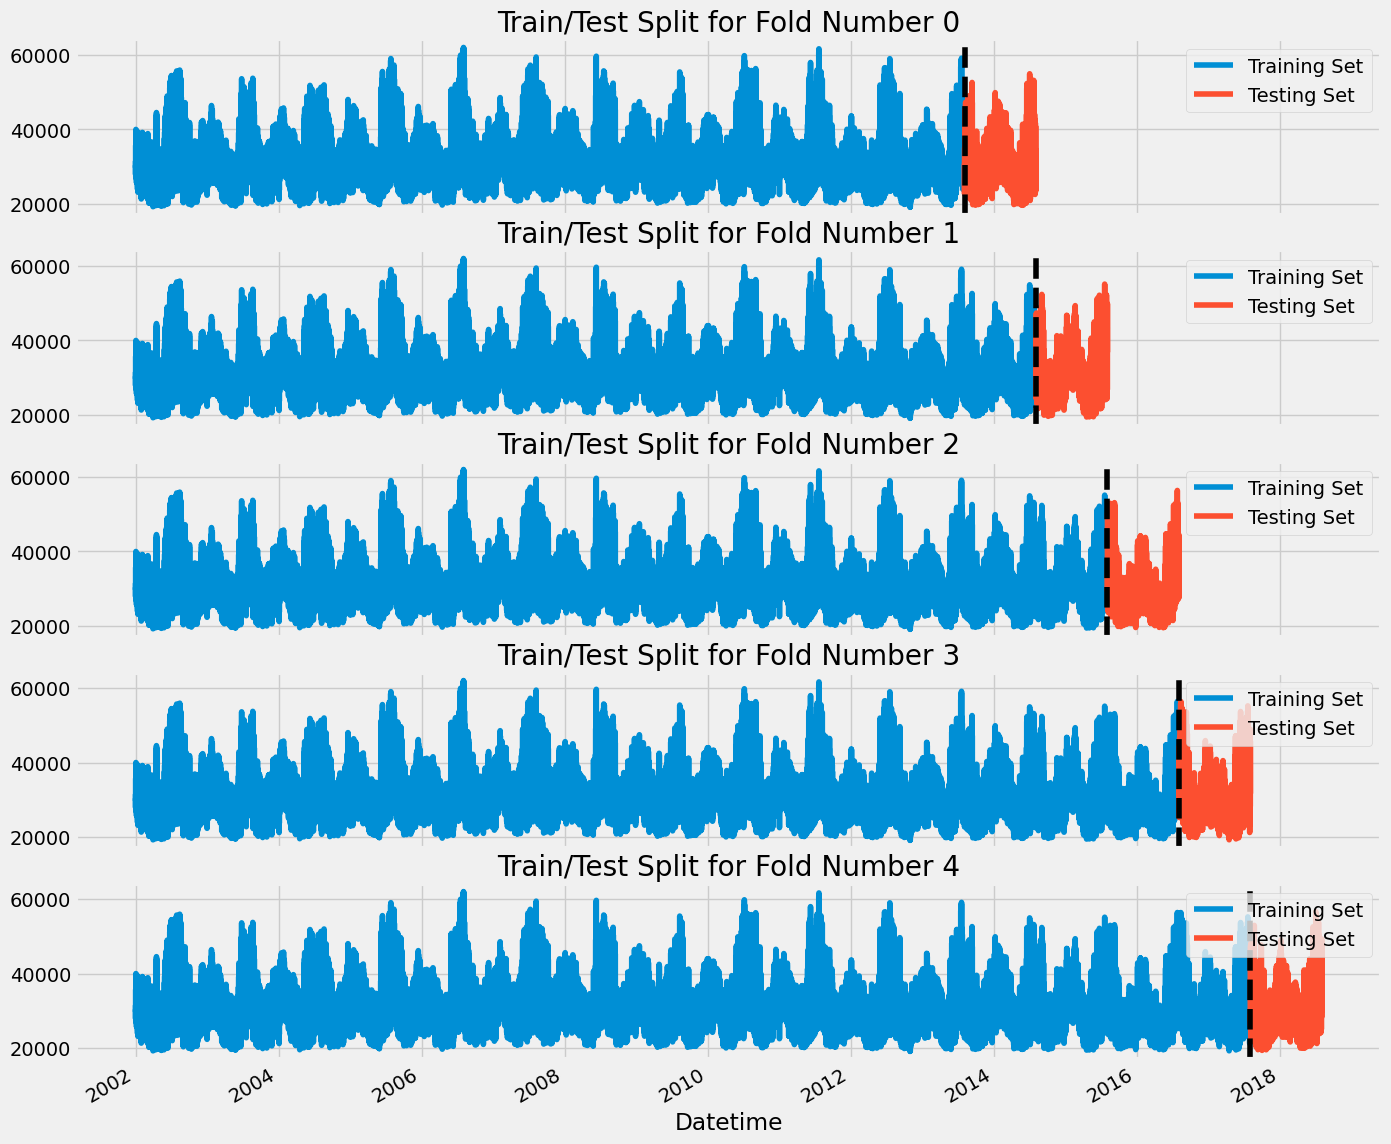

In [36]:
fig, axs = plt.subplots(nrows= 5, ncols= 1, figsize= (15, 15), sharex= True) # they will all share the same x axis

fold = 0
for train_index, test_index in tss.split(df): 
    train = df.iloc[train_index] 
    test = df.iloc[test_index]
    train.plot(ax= axs[fold],
               label= 'Training Set',
               title = f"Train/Test Split for Fold Number {fold}")
    
    test.plot(ax= axs[fold],
              label= 'Testing Set')
    axs[fold].axvline(train.index.max(), color= 'black', ls= '--')
    axs[fold].legend(['Training Set', 'Testing Set'])
    fold += 1
plt.show() 

In [37]:
def create_ts_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

In [38]:
df = create_ts_features(df)

In [39]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1


In [40]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [41]:
# this way when you predict the future you will have the values for the same date but for past years
df = add_lags(df)
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


In [42]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [43]:
tss = TimeSeriesSplit(n_splits= 5, test_size= 24*365*1, gap=0)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_indecies, test_indecies in tss.split(df):
    train = df.iloc[train_indecies]
    test = df.iloc[test_indecies]

    train = create_ts_features(train)
    test = create_ts_features(test)

    features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
    target = ['PJME_MW']

    x_train = train[features]
    y_train = train[target]

    x_test= test[features]
    y_test= test[target]

    reg = xgb.XGBRegressor(base_score = 0.5,
                           booster= 'gbtree',
                           n_estimators= 1000,
                           early_stopping_rounds= 50,
                           objective= 'reg:linear',
                           max_depth= 3,
                           learning_rate= 0.01)
    
    reg.fit(x_train, y_train,
            eval_set = [(x_train, y_train), (x_test, y_test)],
            verbose= 100)
    
    y_pred= reg.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)



[0]	validation_0-rmse:32732.00797	validation_1-rmse:31956.60365


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.92919	validation_1-rmse:11906.95256
[200]	validation_0-rmse:5747.14761	validation_1-rmse:5358.33407
[300]	validation_0-rmse:3872.77656	validation_1-rmse:3897.70763
[400]	validation_0-rmse:3438.10933	validation_1-rmse:3760.17207
[467]	validation_0-rmse:3345.11250	validation_1-rmse:3765.05492
[0]	validation_0-rmse:32671.48572	validation_1-rmse:32138.89403


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.59168	validation_1-rmse:12225.40462
[200]	validation_0-rmse:5755.59562	validation_1-rmse:5665.93778
[300]	validation_0-rmse:3906.55343	validation_1-rmse:3943.16398
[400]	validation_0-rmse:3479.73036	validation_1-rmse:3600.08501
[500]	validation_0-rmse:3353.97400	validation_1-rmse:3523.60973
[600]	validation_0-rmse:3297.39998	validation_1-rmse:3485.95469
[700]	validation_0-rmse:3253.20720	validation_1-rmse:3471.06078
[800]	validation_0-rmse:3214.58702	validation_1-rmse:3454.74409
[827]	validation_0-rmse:3206.01227	validation_1-rmse:3455.30260
[0]	validation_0-rmse:32632.78913	validation_1-rmse:31073.29455


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.83700	validation_1-rmse:11138.17167
[200]	validation_0-rmse:5750.20595	validation_1-rmse:4807.18103
[300]	validation_0-rmse:3917.80778	validation_1-rmse:3538.27134
[400]	validation_0-rmse:3495.54660	validation_1-rmse:3483.74819
[408]	validation_0-rmse:3480.68707	validation_1-rmse:3489.05741
[0]	validation_0-rmse:32529.29856	validation_1-rmse:31475.39699


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.32223	validation_1-rmse:12018.83377
[200]	validation_0-rmse:5737.98324	validation_1-rmse:5787.53321
[300]	validation_0-rmse:3912.61726	validation_1-rmse:4379.67362
[400]	validation_0-rmse:3496.34019	validation_1-rmse:4166.52852
[500]	validation_0-rmse:3380.42139	validation_1-rmse:4123.18673
[600]	validation_0-rmse:3321.84308	validation_1-rmse:4101.43027
[700]	validation_0-rmse:3279.28332	validation_1-rmse:4084.87742
[800]	validation_0-rmse:3247.09462	validation_1-rmse:4080.88777
[812]	validation_0-rmse:3243.79069	validation_1-rmse:4080.44914
[0]	validation_0-rmse:32462.96226	validation_1-rmse:31463.89824


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.89422	validation_1-rmse:11960.06364
[200]	validation_0-rmse:5751.26862	validation_1-rmse:5610.88887
[300]	validation_0-rmse:3949.96000	validation_1-rmse:4155.02010
[400]	validation_0-rmse:3537.17148	validation_1-rmse:4004.82428
[438]	validation_0-rmse:3480.55264	validation_1-rmse:4008.30053


In [44]:
scores

[3758.0020989814675,
 3452.8977897588056,
 3469.001823285164,
 4079.055704779315,
 4000.2777928113983]

In [53]:
# best RMSE scores are for fold number 2 which has index=1
tss = TimeSeriesSplit(n_splits= 5, test_size= 24*365*1, gap=0)
df = df.sort_index()
fold = 0
scores = []
for train_indecies, test_indecies in tss.split(df):
    if fold == 1:
        train = df.iloc[train_indecies]
        test = df.iloc[test_indecies]

        train = create_ts_features(train)
        test = create_ts_features(test)

        features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
        'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
        target = ['PJME_MW']

        x_train = train[features]
        y_train = train[target]

        x_test= test[features]
        y_test= test[target]

        reg_101 = xgb.XGBRegressor(base_score = 0.5,
                            booster= 'gbtree',
                            n_estimators= 1000,
                            early_stopping_rounds= 50,
                            objective= 'reg:linear',
                            max_depth= 3,
                            learning_rate= 0.01)
        
        reg_101.fit(x_train, y_train,
                eval_set = [(x_train, y_train), (x_test, y_test)],
                verbose= 100)
        y_pred = reg_101.predict(x_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred)) 
        scores.append(score)           
    if fold == 0:
        fold = fold + 1
    else:
        break
        

[0]	validation_0-rmse:32671.48572	validation_1-rmse:32138.89403


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.59168	validation_1-rmse:12225.40462
[200]	validation_0-rmse:5755.59562	validation_1-rmse:5665.93778
[300]	validation_0-rmse:3906.55343	validation_1-rmse:3943.16398
[400]	validation_0-rmse:3479.73036	validation_1-rmse:3600.08501
[500]	validation_0-rmse:3353.97400	validation_1-rmse:3523.60973
[600]	validation_0-rmse:3297.39998	validation_1-rmse:3485.95469
[700]	validation_0-rmse:3253.20720	validation_1-rmse:3471.06078
[800]	validation_0-rmse:3214.58702	validation_1-rmse:3454.74409
[827]	validation_0-rmse:3206.01227	validation_1-rmse:3455.30260


In [54]:
scores

[3452.8977897588056]

In [55]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [56]:
# create future dates to forecast consumption
future = pd.date_range('2018-08-03', '2019-08-01', freq= '1h')
future_df = pd.DataFrame(index= future)
future_df['isfuture'] = True
df['isfuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_ts_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [58]:
df_and_future.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isfuture
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True
2019-08-01 00:00:00,NaN,0,3,3,8,2019,213,1,31,37158.0,31646.0,31470.0,True


In [63]:
future_df = df_and_future.query('isfuture == True')
future_df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isfuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True


In [65]:
future_df.describe()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
count,0.0,8713.000000,8713.000000,8713.000000,8713.000000,8713.00000,8713.000000,8713.000000,8713.0,8712.000000,8712.000000,8712.000000
mean,NaN,11.498680,3.000000,2.506944,6.518076,2018.58407,182.835418,15.797200,26.488121,31160.716024,31076.853880,30684.359389
std,NaN,6.923283,2.002753,1.119257,3.455632,0.49291,105.631991,8.758065,15.027206,6029.445556,6593.456682,6424.136749
min,NaN,0.000000,0.000000,1.000000,1.000000,2018.00000,1.000000,1.000000,1.0,19367.000000,19255.000000,19524.000000
25%,NaN,5.000000,1.000000,2.000000,4.000000,2018.00000,91.000000,8.000000,13.0,26992.000000,26680.750000,26197.750000
50%,NaN,11.000000,3.000000,3.000000,7.000000,2019.00000,182.000000,16.000000,26.0,30374.500000,29894.500000,29553.500000
75%,NaN,17.000000,5.000000,4.000000,10.000000,2019.00000,275.000000,23.000000,40.0,34485.000000,34246.250000,34011.500000
max,NaN,23.000000,6.000000,4.000000,12.000000,2019.00000,365.000000,31.000000,52.0,56609.000000,56382.000000,56391.000000


In [66]:
future_df['pred'] = reg_101.predict(future_df[features])

C:\Users\User\AppData\Local\Temp\ipykernel_14540\1696756999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_df['pred'] = reg_101.predict(future_df[features])


Text(0.5, 1.0, 'Future Predictions for a Year')

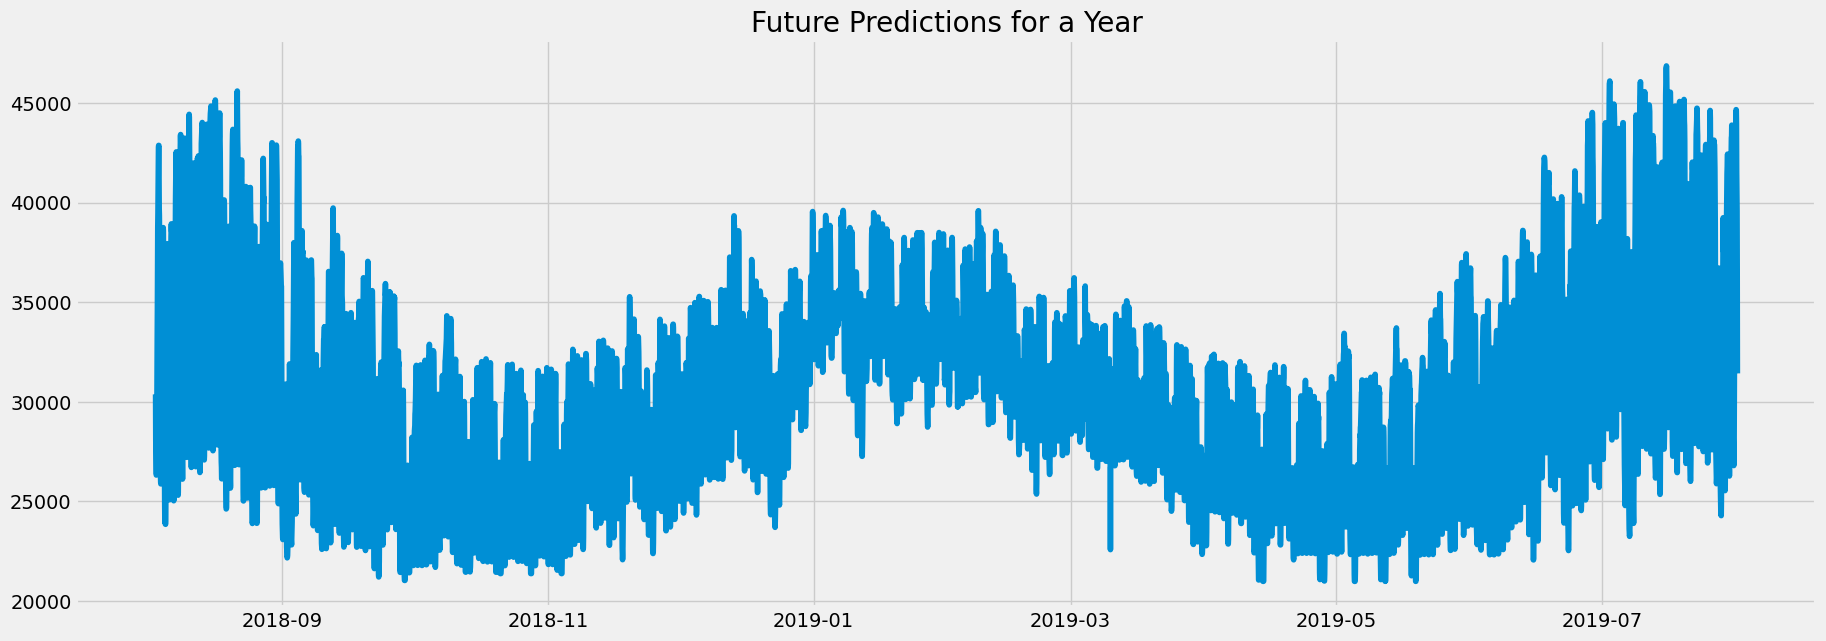

In [71]:
plt.figure(figsize= (20, 7))
plt.plot(future_df.index, future_df['pred'])
plt.title('Future Predictions for a Year')


In [72]:
reg_101.save_model('reg_101.json')

In [75]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('reg_101.json')